<a href="https://colab.research.google.com/github/vexogon/fivekClassifierModelNew/blob/main/Working%20Models/Multi%20Class-shrinked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I decided to balance out the settings to the total of man_made to see if that helps the model learn better, now each setting has around 1800 images.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pandas import DataFrame
from torch import nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torcheval

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Numpy and Pandas FutureWarnings - ignore them for now, we can fix them later

Reading in our CSV file, and doing some preprocessing to get it ready for training

In [5]:
df = pd.read_csv('categories_settings_balanced.csv')
df.head()

,img_name,location,time_of_day,skyCondition,setting
0,a0001-jmac_DSC1459,outdoor,day,sun_sky,nature
1,a0002-dgw_005,indoor,day,mixed,people
2,a0003-NKIM_MG_8178,outdoor,day,sun_sky,man_made
3,a0004-jmac_MG_1384,outdoor,day,sun_sky,nature
4,a0005-jn_2007_05_10__564,outdoor,day,sun_sky,man_made


Lets drop all the columns that aren't one for our classes for multilabel classification, so thats location, time_of_day, skyCondition

In [6]:
df = df.drop(columns=['location','time_of_day','skyCondition'])

Nows lets one-hot encode the 'setting' column, so we have a column for each setting type, with a 1 if the image is of that setting type, and a 0 if it isn't

In [7]:
df = pd.get_dummies(df, columns=['setting'], dtype='long')
df.columns

Index(['img_name', 'setting_abstract', 'setting_animals', 'setting_man_made',
       'setting_nature', 'setting_people'],
      dtype='object')

Restoring abstract column, found data from another dataset to balance it out, now all settings have around 1800 images

In [8]:
# df.drop('setting_abstract', axis=1, inplace=True) #Abstract doesn't have enough examples
df.head()

,img_name,setting_abstract,setting_animals,setting_man_made,setting_nature,setting_people
0,a0001-jmac_DSC1459,0,0,0,1,0
1,a0002-dgw_005,0,0,0,0,1
2,a0003-NKIM_MG_8178,0,0,1,0,0
3,a0004-jmac_MG_1384,0,0,0,1,0
4,a0005-jn_2007_05_10__564,0,0,1,0,0


Removing any rows without a one-hot encoded class, as they will distract the model during training

In [9]:
#Remove any rows without any class
filtered_df = df[(df == 1).any(axis=1)]
print(filtered_df)
df = filtered_df #Set as main dataset

                                    img_name  setting_abstract  \
0                         a0001-jmac_DSC1459                 0   
1                              a0002-dgw_005                 0   
2                         a0003-NKIM_MG_8178                 0   
3                         a0004-jmac_MG_1384                 0   
4                   a0005-jn_2007_05_10__564                 0   
...                                      ...               ...   
9706             abstract_jean-fautrier_4267                 1   
9707               abstract_sam-francis_4697                 1   
9708           abstract_ellsworth-kelly_6823                 1   
9709  abstract_huguette-arthur-bertrand_1495                 1   
9710          abstract_william-baziotes_1344                 1   

      setting_animals  setting_man_made  setting_nature  setting_people  
0                   0                 0               1               0  
1                   0                 0               0    

Setting the device to use for training, in this case a GPU if available

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")

Our custom dataset class, which will read in the images and labels from the CSV file and image directory, this is greatly simplified and much much faster compared with the raw image version in earlier notebooks, check model.ipynb for that

In [11]:
from torchvision.io import decode_image
from torchvision.io import ImageReadMode

class ImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.transform = transform
        self.img_dir = img_dir
        self.bounds = []

        if not self.img_dir:
            raise ValueError(f"No images found in directory: {img_dir}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['img_name']  # Assuming the first column is 'img_name'
        #Get the label tensor from the row, excluding the first column (img_name)
        label = torch.tensor(row[1:], dtype=torch.long)  # Convert the labels to tensor (excluding img_name, which is the input image name)

        img_path = os.path.join(self.img_dir, img_name) + ".jpg" # Full path to the image file
        image = decode_image(img_path, mode=ImageReadMode.RGB) #outputs tensor of shape (C, H, W) where C is the number of channels, H is the height and W is the width

        if self.transform:
            image = self.transform(image)

        return image, label

Standard transformations for the dataset, and data augmentation for the training set

In [12]:
# Transformations for the dataset

# These are the standard transformations for the dataset, we will use these for training, testing, and validation
val_test_standard_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.Resize((512, 512)), # Resize the image to 512x512 for consistency and to match the model input size
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


This is our data augmentation for the training set, to get more unique data and prevent overfitting, these transformations are applied dynamically during training, so sample images will be different each time, effectively increasing the size of the training set

In [13]:
#Doing data augmentation for training set to get more data and prevent overfitting
#These are applied to the training set only, not the validation or test set
#They are applied dynamically during training, so sample images will be different each time, effectively increasing the size of the training set


#Training transformations with data augmentation
training_augmentation_transforms = transforms.Compose([
    #Standard transformations for the dataset, we will still use these for training (rest below)
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    #Data augmentation transformations for training
    # p= probability of applying the transformation, 0.2 means 20% chance of applying the transformation

    #RandomApply makes any transformation randomly applied with a probability p, so we can apply the same transformation with a probability of 0.2

    #20% chance of:
    transforms.RandomApply(
      [
          transforms.RandomCrop(size=430, pad_if_needed=True)
      ], # Randomly crop the image to 430 in random locations, pad if needed to maintain the size for input to the model (82 pixels on each side, so 82+430+82=512)
      p=0.2),


    #20% chance of:
    transforms.RandomApply(
        [
            transforms.RandomRotation(30)
        ],
        p=0.2),

    #20% chance of:
    transforms.RandomApply(
        [
            transforms.RandomRotation(90)
        ],
        p=0.2),

    #20% chance of:
      transforms.RandomApply([
      transforms.ColorJitter(
          brightness=0.3,   # +/- 30% brightness
          contrast=0.3,     # +/- 30% contrast
          saturation=0.3,   # +/- 30% saturation
          hue=0.1           # +/- 0.1 hue shift (~36 degrees)
      )
  ], p=0.2),

    transforms.RandomGrayscale(p=0.1),

    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.2), # Randomly adjust the sharpness of the image
    transforms.RandomAdjustSharpness(sharpness_factor=0.5,p=0.2), # Randomly adjust the sharpness of the image

    transforms.Resize((512, 512)), # Resize the image to 512x512 for consistency and to match the model input size
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Splitting the dataset into training, validation, and test sets, 70% training, 15% validation, 15% test, in order to get transformations applied dynamically during training, we need to create the datasets after the split

In [14]:
from sklearn.model_selection import train_test_split
# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42) # 70% training, 30% test
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)  # Split the test set into validation and test sets
#This gives us 70% training, 15% validation, and 15% test sets

Creating the datasets with the appropriate transformations using train_df val_df and test_df

In [15]:
train_dataset = ImageDataset(train_df, img_dir='raw_images_organised_settings', transform=training_augmentation_transforms)  # Create the training dataset with data augmentation
test_dataset = ImageDataset(test_df, img_dir='raw_images_organised_settings', transform=val_test_standard_transforms)  # Create the test dataset with standard transformations
val_dataset = ImageDataset(val_df, img_dir='raw_images_organised_settings', transform=val_test_standard_transforms)  # Create the validation dataset with standard transformations

In [16]:
print(train_dataset.transform)
print(test_dataset.transform)
print(val_dataset.transform)

Compose(
      ToPILImage()
      RandomApply(    RandomCrop(size=(430, 430), pad_if_needed=True, fill=0, padding_mode=constant))
      RandomApply(    RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0))
      RandomApply(    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1)))
      RandomGrayscale(p=0.1)
      RandomAdjustSharpness(p=0.2, sharpness_factor=2)
      RandomAdjustSharpness(p=0.2, sharpness_factor=0.5)
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
Compose(
      ToPILImage()
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
Compose(
      ToPILImage()
      Resize(size=[512, 512], interpolation=

These will produce the batches for training, validation, and testing, shuffling the training data to prevent overfitting. These are what creates that shape (batch_size, channels, height, width) for the model input. in order case of (32, 3, 512, 512) for a batch size of 32, 3 channels (RGB), and 512x512 image size

Lower batch sizes means more randomness in how the batches are created, helping with overfitting

In [17]:
#Data loaders for batching and shuffling the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
train_images, train_labels = next(iter(train_loader))
print(train_images.shape, train_labels.shape)

torch.Size([32, 3, 512, 512]) torch.Size([32, 5])


Rendering some sample images from the training set to check that the data augmentation is working as expected

torch.float32
torch.int64


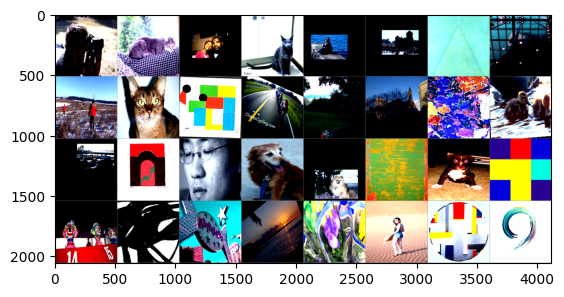

In [19]:
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print(train_images.dtype)  # Check the shape of the images tensor
print(train_labels.dtype)  # Check the shape of the labels tensor

imshow(make_grid(train_images))

Class weights to handle class imbalance, using custom function based on sklearn's compute_class_weight function

In [20]:
#n_samples / (n_classes * np.bincount(y))

#Build my own class weight function

def class_weights(data: DataFrame):
    weights = []
    for col in data.columns[1:]:  # Skip the first column (img_name)
        classes = data[col].unique()
        total_samples = len(data[col])
        class_weight = total_samples / (len(classes) * data[col].value_counts())
        weights.append(class_weight[1]) # Assuming the positive class is the second one (1)
    class_weights = torch.tensor(weights, dtype=torch.float32)

    return class_weights

Because i balanced the settings to be around 1800 each, the class weights are all around 1, so not needed anymore

In [21]:
# weights = class_weights(df)
# print(weights)

Cross entropy loss function for multiclass classification, with class weights to handle class imbalance, and moving it to the appropriate device (GPU if available). this cost function combines softmax and negative log likelihood loss, so we don't need to apply softmax to the model outputs before passing them to the loss function

In [22]:
# #Applyimg multiclass classification loss function
# criterion = nn.CrossEntropyLoss(weight=weights).to(device) #Contains softmax and negative log likelihood loss

In [23]:
criterion = torch.nn.CrossEntropyLoss().to(device) #Contains softmax and negative log likelihood loss, no longer needs class weights set because i balanced the dataset

Our model architecture, a CNN with 9 convolutional layers, batch normalization, dropout, max pooling, and global average pooling before the final fully connected layer for classification. Using ReLU activation functions after each convolutional layer to introduce non-linearity. The model is designed to take in 512x512 RGB images and output class scores for each of the classes in the dataset. These can then have argmax applied to get the predicted class for each image, creating class indices (0,1,2,3) which is what CrossEntropyLoss wants, instead of one-hot

If you make a model too big that itself can cause it to learn complex patterns which create overfitting

In [24]:
#https://arxiv.org/pdf/1512.03385
#Decided to copy what paper is doing with kernal sizes etc
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2) # Input channels = 3 (RGB), output channels = 32, kernel size = 5x5, stride = 1, padding = 2 (to keep the spatial dimensions the same)

        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        #Channels are the amount of filters applied to our spatial data, giving depth to our feature map
        #The spatial data will shrink because of 'edge issue' with CNN look at notes for more details
        self.bn7 = nn.BatchNorm2d(128)

        self.avg_global_pool = nn.AdaptiveAvgPool2d(1) # Global average pooling converts our (batch size, num_channels, height width) spatial dimensions into the average per channel across the height and width of the image.
        #This makes our shape (batch_size, num_channels, 1,1) containing just the average per each channel across the image (height and width)
        #for us its (batch_size, 64, 1,1)
        #once flattened this becomes (batch_size, 64 (channels))
        #This avoids us needing a fully connected layer with loads of parameters to deal with the large spatial dimensions

        self.fc1 = nn.Linear(128, num_classes) #Classification layer
    def forward(self, x):
        # Input x is of shape (batch_size, 3, 512, 512)
        x = self.conv1(x)
        #Spatial data: output shape will be (batch_size, 64, 512, 512) because of padding=2

        x = self.bn1(x) #Batch normalization to stabilize and speed up training by normalizing the activations of the previous layer
        x = F.relu(x) #ReLU activation function to bring non-linearity to the model

        x = self.conv2(x)
        #Spatial data: output shape will be (batch_size, 64, 510, 510) because of no padding and kernel size of 3

        x = self.bn2(x)
        x = F.relu(x)
        # x = self.dropout(x) removing dropout to increase stability of training, increasing L2 regularization and augmentation instead


        x = self.conv3(x)
        #Spatial data: output shape will be (batch_size, 64, 508, 508) because of no padding and kernel size of 3

        x = self.bn3(x)
        x = F.relu(x)

        x = self.max_pool(x)  # Max pooling layer, reduces the spatial dimensions by half, you should only pool after a few convolutional layers
        #This will take only the most important features from the feature map, and reduce the spatial dimensions to (batch_size, 64, 254, 254)

        x = self.conv4(x)
        #Spatial data: output shape will be (batch_size, 128, 252, 252) because of no padding and kernel size of 3

        x = self.bn4(x)
        x = F.relu(x)
        # x = self.dropout(x) removing dropout to increase stability of training, increasing L2 regularization and augmentation instead

        x = self.conv5(x)
        #Spatial data: output shape will be (batch_size, 128, 250, 250) because of no padding and kernel size of 3

        x = self.bn5(x)
        x = F.relu(x)

        x = self.conv6(x)
        #Spatial data: output shape will be (batch_size, 128, 248, 248) because of no padding and kernel size of 3

        x = self.bn6(x)
        x = F.relu(x)

        x = self.max_pool(x)  # Max pooling layer, reduces the spatial dimensions by half
        #This will take only the most important features from the feature map, and reduce the spatial dimensions to (batch_size, 128, 124, 124)

        x = self.conv7(x)
        #Spatial data: output shape will be (batch_size, 256, 122, 122) because of no padding and kernel size of 3

        x = self.bn7(x)
        x = F.relu(x)

        #At the end here our spatial data is 122*122*256 channels because each filter gives an output per location in the spatial data

        #So we have 256 filters, each giving an output for each of the 122*122 locations in the spatial data

        #This is a lot of data, and would require a huge fully connected layer to process it all, so we use global average pooling to reduce the spatial dimensions to an average per channel across the height and width of the image
        #Making its output: (batch_size, 128, 1, 1)
        x = self.avg_global_pool(x)


        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer, keeping the batch dimension into (batch_size, 256)

        x = self.fc1(x)  # Fully connected layer for classification

        return x

    def train_epoch(self, train_loader, loss_values):
        running_loss = 0.0 #Running loss for the epoch, we will average it later

        # Every data instance is an input + label pair, in a batch of 32
        for i, data in enumerate(train_loader): #enumerate give us a counter as well as the data
            inputs, labels = data #Get the inputs and labels from the batch
            #Has to be .float for CrossEntropyLoss
            inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)  # changes label to class indices (1,2,3,4) which is what CrossEntropyLoss wants, instead of one-hot

            optimizer.zero_grad() # Zero your gradients for every batch!

            outputs = self(inputs) # Make predictions for this batch (forward pass)

            loss = criterion(outputs, labels) # Calculate the loss for this batch using the cost function defined earlier
            loss.backward()  # Backpropagate the loss for this batch (backward pass)

            optimizer.step() # Adjust learning weights with gradient descent, using the gradients from backpropagation (step the optimizer)
            running_loss += loss.item() # running_loss is the total loss for the epoch, we will average it later

        avg_loss = running_loss / len(train_loader) # Average loss for the epoch (over the all batches in the training set, given by len(train_loader))

        loss_values.append(avg_loss) #log the average loss for the epoch to the loss_values list
        return avg_loss, loss_values

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
model = Model(5).to(device)  # 5 classes

L2 regularization to prevent overfitting, Adam optimizer for training the model, with a learning rate of 0.001 and weight decay of 1e-8 for L2 regularization
This optimizer will update the model weights during training to minimize the loss function.

Adams optimizer it gives each weight its own learning rate

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8) #Increasing weight decay to 1e-8 to see if it helps with overfitting

This doesn't seem to be working properly, so disabling it for now, but keeping the code here in case we want to try it again later

In [28]:
recent_train_losses = []  # List to keep track of recent training losses for early stopping
previous_train_losses = []

#This was broken - made a change idk now
def early_stopping(avg_loss,patience=5):

    if len(recent_train_losses) < patience:
        recent_train_losses.append(avg_loss)  # Add the current average loss to the recent losses

    if len(previous_train_losses) < patience:
        previous_train_losses.append(recent_train_losses[0])
        recent_train_losses.pop(0)

    if len(recent_train_losses) == patience and len(previous_train_losses) == patience:
        avg_of_previous_losses = np.mean(previous_train_losses)
        avg_of_recent_previous_losses = np.mean(recent_train_losses)
        if avg_of_previous_losses < avg_of_recent_previous_losses:
            print(f"Early stopping condition met: {avg_of_previous_losses} < {avg_of_recent_previous_losses}")
            return True, recent_train_losses, previous_train_losses  # Early stopping condition met

        print(f"Early stopping condition not met: {avg_of_previous_losses} >= {avg_of_recent_previous_losses}")
        previous_train_losses.append(recent_train_losses[0])  #Add oldest recent loss to previous losses
        recent_train_losses.pop(0)  # Remove the oldest loss to maintain the size of the list

    return False, recent_train_losses, previous_train_losses  # No early stopping condition met


In [ ]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

#There's a bunch of tensorboard stuff in the pytorch tutorial, we don't need it for now, but we can add it later if we want to visualize the training process
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/classifier_trainer{}'.format(timestamp))

EPOCHS = 100

best_vloss = 1_000_000. #Super big number to start with, so we can save the model if the validation loss is lower than this

# Initialize lists to keep track of loss values for plotting later
loss_values = []
val_loss_values = []


total_val_data = len(val_loader)
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1)) # Start counting epochs from 1 for better readability

    # Make sure gradient tracking is on, and do a pass over the data, so we are not in evaluation mode.
    model.train(True)

    #Actually train the model, this is where the training happens
    #Keep track of loss values for plotting later, keep giving the loss_values array to the train_one_epoch function so that it keeps track of the loss values
    avg_loss, loss_values = model.train_epoch(train_loader, loss_values)

    early_stop,recent_train_losses, previous_train_losses = early_stopping(avg_loss,patience=5)  # Check if early stopping condition is met

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    #This is the validation loop, it will run after each epoch and compute the validation loss
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader, 0): #Computes the validation loss per epoch
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), torch.argmax(vlabels, dim=1).to(device) #changes label to class indices (1,2,3,4) which is what CrossEntropyLoss wants, instead of one-hot
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            #running vloss is the total validation loss for the epoch, we will average it later
            running_vloss += vloss.item()  # Add the validation loss for this batch to the running validation loss

    # Average validation loss for the epoch (over the all batches in the validation set, given by len(val_loader))
    avg_vloss = running_vloss / total_val_data
    val_loss_values.append(avg_vloss)

    #Gives the loss and validation loss for the epoch into the terminal
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # for both training and validation w]e log the average loss for the epoch
    writer.add_scalars('Training vs. Validation Loss',
                       { 'Training' : avg_loss, 'Validation' : avg_vloss },
                       epoch + 1)
    writer.flush()

    #Track best performance, and save the model's state
    if avg_vloss < best_vloss: #If the validation loss is lower than the best validation loss so far, save the model

        #Best vloss starts at a super high number, so the first model will always be saved
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch + 1) # Save the model with a timestamp and epoch number (epoch + 1 to start from 1)
        torch.save(model.state_dict(), model_path)

#Disabling early stopping
    # if early_stop:  # Check if early stopping condition is met
    #     print("Early stopping triggered, stopping training.")
    #     break  # Stop training if early stopping condition is met

    #Onto the next epoch, which will also run through all the batches in the training set and validation set and give the average los s for the epoch

EPOCH 1:
LOSS train 1.4102946758270263 valid 1.3457944176413796
EPOCH 2:
LOSS train 1.3804003206695 valid 1.3044247329235077
EPOCH 3:
LOSS train 1.3448599419942717 valid 1.2231659401546826
EPOCH 4:
LOSS train 1.2752248577955292 valid 1.333299932154742
EPOCH 5:


In [ ]:
#Plot the training and validation loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
#Training set evaluation
from torcheval.metrics import MulticlassAccuracy #This lib has so many of these - good to use i think
model.eval() #Turns off dropout layers
metric = MulticlassAccuracy()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)  # Move inputs and labels to the same device as the model
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class indices
        metric.update(preds, labels)  # Update the metric with predictions and true labels

accuracy = metric.compute()  # Compute the accuracy
print(f'Training set accuracy: {accuracy:.4f}')  # Print the accuracy

In [ ]:
#Test set evaluation
model.eval()
metric = MulticlassAccuracy()
predictions = []
labels_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)  # Move inputs and labels to the same device as the model
        outputs = model(inputs)
        prediction = torch.argmax(outputs, dim=1)  # Get the predicted class indices
        predictions.append(prediction)
        labels_list.append(labels) #append all labels that appeared during the test set evaluation
        metric.update(prediction, labels)  # Update the metric with predictions and true labels

accuracy = metric.compute()  # Compute the accuracy
print(f'Test set accuracy: {accuracy:.4f}')  # Print the accuracy

In [ ]:
torch.save(model.state_dict(), "final_model_mutlilabel.pth")  # Save the final model state dictionary

In [ ]:
#Plot a confusion matrix (prepping data for it)
#https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# Concatenate all predictions and labels into a single tensor (currently they are lists of tensors)

#Basically by counting the amount of each class number that appear in this tensor, we can get the confusion matrix  (cell below)
all_predictions_tensor = torch.cat(predictions, dim=0) # Concatenate all predictions that appeared in the test set into a single tensor
all_labels_tensor = torch.cat(labels_list, dim=0)  # Concatenate all labels that appeared in the test set into a single tensor


# Convert to CPU tensors then to numpy arrays for confusion matrix
all_predictions_tensor = all_predictions_tensor.cpu().numpy()
all_labels_tensor = all_labels_tensor.cpu().numpy()
print(all_predictions_tensor.shape, all_labels_tensor.shape)  # Check the shapes of the tensors
print(all_predictions_tensor[0].shape, all_labels_tensor[0].shape) # Check the shape of the first prediction and label tensors


#Data datatype before argmax, they are one-hot encoded tensors (boolean tensors) no good for confusion matrix
print(all_predictions_tensor.dtype, all_predictions_tensor.dtype)

# Argmax to convert one-hot encoded predictions and labels to a list of predicted and actual labels as integers
print(all_predictions_tensor.dtype, all_labels_tensor.dtype)


print(np.unique(all_predictions_tensor))
print(np.unique(all_labels_tensor)) #Aah, there were only 7 unique labels in the test set
# so we need to make sure the confusion matrix doesn't drop the 'empty labels' because the model might still have predicted them, but it could have been wrong


In [ ]:
display_labels = df.columns[1:]  # Exclude the first column (img_name) for display labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(all_labels_tensor, all_predictions_tensor, labels=np.arange(len(display_labels)))
#np.arrange basically just creates an array of length of display_labels (array of 15 elements, 0 to 14) which are the labels for the possible labels in the dataset, so the confusion matrix will have 15 rows and 15 columns, one for each label

#Without display_labels the confusion matrix would only render the labels that were actually predicted, so if a label was never predicted, it would not appear in the confusion matrix, which is not what we want

#15 labels, so 15x15 matrix
print(cm.shape)

matrix = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels) #disiplay_labels are the text labels (from column names) for the confusion matrix, these are the labels we want to display on the x and y axis of the confusion matrix, these are the same order as the labels we used for confusion matrix computation above,thanks to np.arrange(), so they will line up correctly

_, ax = plt.subplots(figsize=(10, 10))  # Create a figure and axis for the confusion matrix plot (much larger than default
matrix.plot(cmap='Blues', values_format='d', ax=ax, xticks_rotation=90)  # Plot the confusion matrix with blue color map and integer format


In [ ]:
count_all_zeros = (df == 0).all(axis=1).sum()

print(count_all_zeros)

In [ ]:
# Count rows where more than one column has value 1
count_more_than_one_1 = (df == 1).sum(axis=1).gt(1).sum()

print(count_more_than_one_1)